In [33]:
# ============================================
# 0) Imports & setup
# ============================================
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score


import joblib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

pd.set_option("display.max_columns", None)


In [34]:
# ============================================
# 1) Load data
# ============================================
df = pd.read_csv("../data/german_credit_data.csv")

print(df.shape)
df.info()
df.head()


(1000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [35]:
# ============================================
# 2) Basic cleaning: drop technical columns
# ============================================
# 'Unnamed: 0' is just a row index coming from CSV export
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

print(df.shape)
df.info()
df.head()



(1000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [36]:
# ============================================
# 3) Handle missing values
# - Business-friendly imputation for accounts: use a category "unknown"
# ============================================
for col in ["Saving accounts", "Checking account"]:
    if col in df.columns:
        df[col] = df[col].fillna("unknown")

# quick check
df[["Saving accounts", "Checking account"]].isna().sum()


Saving accounts     0
Checking account    0
dtype: int64

In [37]:
# ============================================
# 4) Encode categoricals (Label Encoding)
# Note: we store fitted encoders to reuse later (dashboard / new data).
# ============================================
cat_cols = ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose"]
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le  # keep for inference

# quick check
df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,4,0,1169,6,5
1,22,0,2,1,0,1,5951,48,5
2,49,1,1,1,0,3,2096,12,3
3,45,1,2,0,0,0,7882,42,4
4,53,1,2,0,0,0,4870,24,1


In [38]:
# ============================================
# 5)Scale numeric columns (Optional now, useful for distance-based models) 
# ============================================
num_cols = ["Age", "Duration", "Credit amount"]
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

# quick check
# print("Original values:")
# print(df[num_cols].describe().round(3))

# quick check
# print("\nScaled values:")
# print(df_scaled[num_cols].describe().round(3))

# Compare original vs scaled side by side
desc_original = df[num_cols].describe().round(3)
desc_scaled = df_scaled[num_cols].describe().round(3)

# differentiate column names
desc_original.columns = [col + " (original)" for col in desc_original.columns]
desc_scaled.columns  = [col + " (scaled)" for col in desc_scaled.columns]

# concatenate side by side
comparison = pd.concat([desc_original, desc_scaled], axis=1)
comparison

,Age (original),Duration (original),Credit amount (original),Age (scaled),Duration (scaled),Credit amount (scaled)
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,35.546,20.903,3271.258,0.000,0.000,0.000
std,11.375,12.059,2822.737,1.001,1.001,1.001
min,19.000,4.000,250.000,-1.455,-1.402,-1.071
25%,27.000,12.000,1365.500,-0.752,-0.739,-0.675
50%,33.000,18.000,2319.500,-0.224,-0.241,-0.337
75%,42.000,24.000,3972.250,0.568,0.257,0.248
max,75.000,72.000,18424.000,3.470,4.239,5.371


### Note on Outliers in Credit Amount

After doing some research, I decided **not to remove the outliers** in the credit amount column.  
Here’s why:

- In financial datasets, extreme values are not always errors. They often occur naturally because financial data usually has **heavy-tailed distributions** (large values are part of the domain).
- Simply removing high or low values can actually harm the analysis and cause us to lose important information.
- Outliers may sometimes be the **most informative cases**, showing interesting customer behaviors.

**Conclusion**: For this project, I will **keep all outlier values** and not perform any removal. Instead, I will document this choice and rely on proper analysis and modeling techniques to handle them responsibly.


## Outlier Visualization

To better understand the outliers in the dataset, I performed scatter plot analyses.  
- Compared Age, Credit Duration, and Credit Amount in pairs.  
- Examined both the raw and the scaled data.  
- With the help of mean lines, I was able to see the data center and points deviating from it more clearly.  

This visualization created an environment where I could analyze and examine the data in a more effective way.


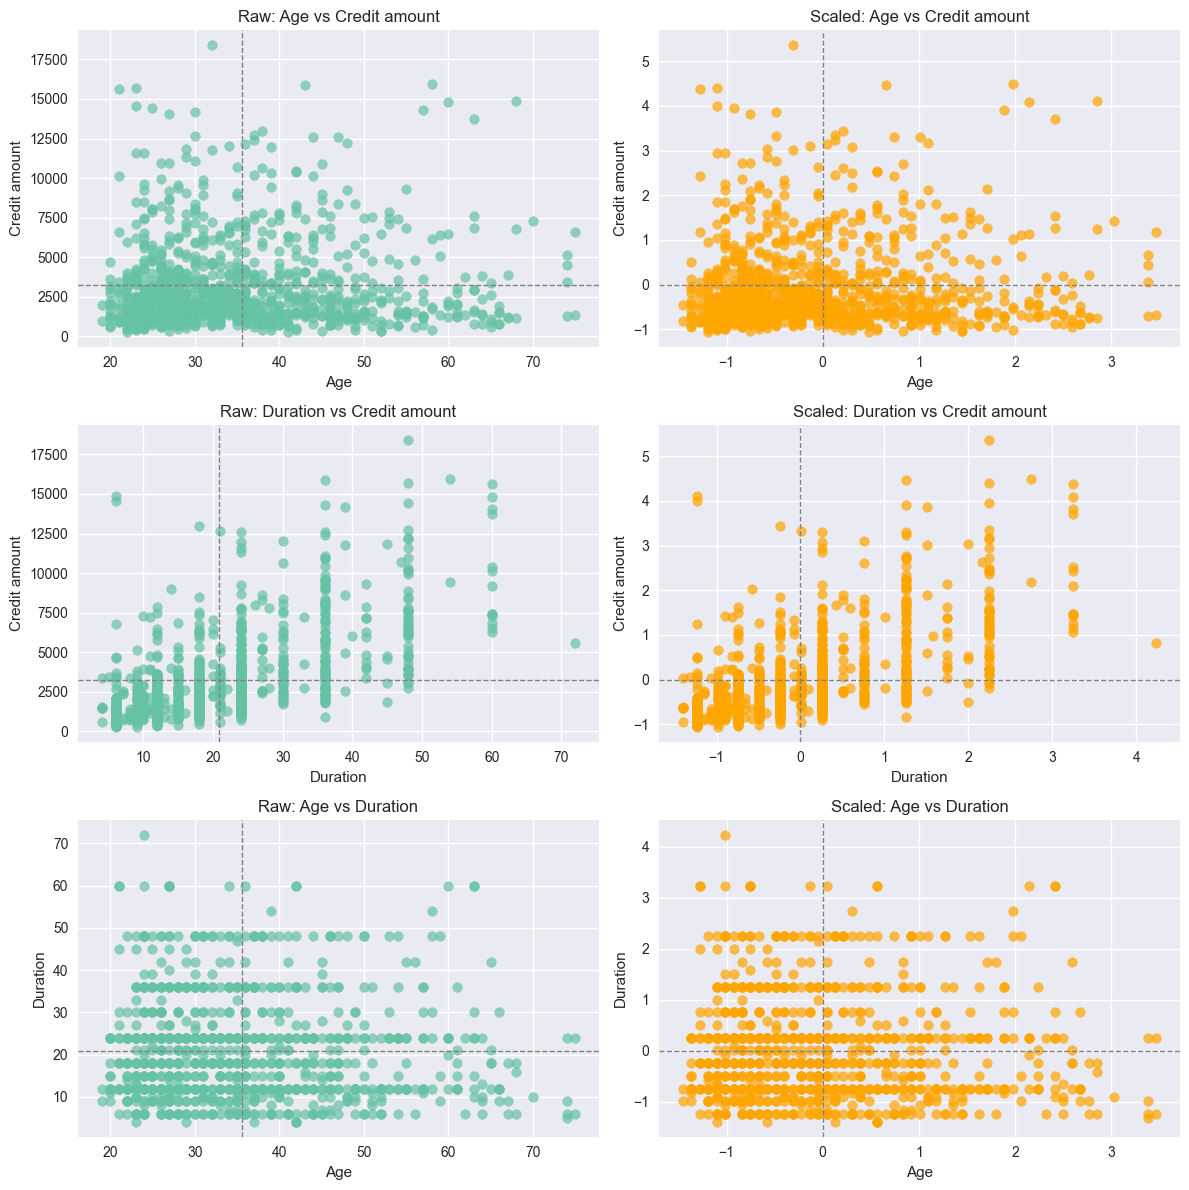

Saved individual figures to: ../images/outliers


In [39]:
# ============================================
# Scatter plots with mean lines (raw vs scaled)
# ============================================

pairs = [
    ("Age", "Credit amount"),
    ("Duration", "Credit amount"),
    ("Age", "Duration"),
]

# Save directory 
out_dir = "../images/outliers"
os.makedirs(out_dir, exist_ok=True)

def _safe(name: str) -> str:
    return name.lower().replace(" ", "_")

# Visualize in grid (6 plots) + mean lines  
fig, axes = plt.subplots(len(pairs), 2, figsize=(12, 12))
for i, (x_col, y_col) in enumerate(pairs):
    # ----- RAW -----
    ax = axes[i, 0]
    ax.scatter(df[x_col], df[y_col], alpha=0.7)
    ax.set_title(f"Raw: {x_col} vs {y_col}")
    ax.set_xlabel(x_col); ax.set_ylabel(y_col)
    ax.axvline(df[x_col].mean(), ls="--", lw=1, color="grey")
    ax.axhline(df[y_col].mean(), ls="--", lw=1, color="grey")

    # ----- SCALED -----
    ax = axes[i, 1]
    ax.scatter(df_scaled[x_col], df_scaled[y_col], alpha=0.7, color="orange")
    ax.set_title(f"Scaled: {x_col} vs {y_col}")
    ax.set_xlabel(x_col); ax.set_ylabel(y_col)
    ax.axvline(df_scaled[x_col].mean(), ls="--", lw=1, color="grey")
    ax.axhline(df_scaled[y_col].mean(), ls="--", lw=1, color="grey")

plt.tight_layout()
plt.show()

# Save each plot as a separate file  
for (x_col, y_col) in pairs:
    # RAW
    plt.figure(figsize=(6, 4))
    plt.scatter(df[x_col], df[y_col], alpha=0.7)
    plt.title(f"Raw: {x_col} vs {y_col}")
    plt.xlabel(x_col); plt.ylabel(y_col)
    plt.axvline(df[x_col].mean(), ls="--", lw=1, color="grey")
    plt.axhline(df[y_col].mean(), ls="--", lw=1, color="grey")
    raw_path = os.path.join(out_dir, f"raw_{_safe(x_col)}_vs_{_safe(y_col)}.png")
    plt.tight_layout(); plt.savefig(raw_path, dpi=150); plt.close()

    # SCALED
    plt.figure(figsize=(6, 4))
    plt.scatter(df_scaled[x_col], df_scaled[y_col], alpha=0.7, color="orange")
    plt.title(f"Scaled: {x_col} vs {y_col}")
    plt.xlabel(x_col); plt.ylabel(y_col)
    plt.axvline(df_scaled[x_col].mean(), ls="--", lw=1, color="grey")
    plt.axhline(df_scaled[y_col].mean(), ls="--", lw=1, color="grey")
    sc_path = os.path.join(out_dir, f"scaled_{_safe(x_col)}_vs_{_safe(y_col)}.png")
    plt.tight_layout(); plt.savefig(sc_path, dpi=150); plt.close()

print(f"Saved individual figures to: {out_dir}")


In [40]:
# ============================================
# 6) Save preprocessed artifacts
# ============================================
df.to_csv("../data/german_credit_data_clean.csv", index=False) # cleaned + encoded dataset
df_scaled.to_csv("../data/german_credit_data_clean_scaled.csv", index=False) # cleaned + encoded + scaled dataset (ready for modeling)

joblib.dump(encoders, "../models/label_encoders.pkl")
joblib.dump(scaler, "../models/standard_scaler.pkl")

print("Saved:")
print(" - ../data/german_credit_data_clean.csv")
print(" - ../data/german_credit_data_clean_scaled.csv")
print(" - ../models/label_encoders.pkl")
print(" - ../models/standard_scaler.pkl")


Saved:
 - ../data/german_credit_data_clean.csv
 - ../data/german_credit_data_clean_scaled.csv
 - ../models/label_encoders.pkl
 - ../models/standard_scaler.pkl
